In [ ]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
file_path = '/content/ecommercedata.csv'
df = pd.read_csv(file_path, encoding='latin1')

# Display first few rows of the dataset
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/01/2010 08:26,2.55,17850.0,United Kingdom,NaN,NaN,NaN,NaN,NaN
1,536365,71053,WHITE METAL LANTERN,6,12/01/2010 08:26,3.39,17850.0,United Kingdom,NaN,NaN,NaN,NaN,NaN
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/01/2010 08:26,2.75,17850.0,United Kingdom,NaN,NaN,NaN,NaN,NaN
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/01/2010 08:26,3.39,17850.0,United Kingdom,NaN,NaN,NaN,NaN,NaN
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/01/2010 08:26,3.39,17850.0,United Kingdom,NaN,NaN,NaN,NaN,NaN


1.	What are the trends in product sales over time?
Analyse sales over different time periods (daily, weekly, monthly) to identify seasonal trends, peak sales periods, and any unusual fluctuations.


Summary:

The first step involves importing necessary libraries like Pandas for data manipulation and Matplotlib for visualisation. The dataset is loaded into a DataFrame from the provided CSV file path, and the initial few rows are displayed to understand its structure.

Data Preprocessing

Before analysing trends, the InvoiceDate column is converted to datetime for easier time-based grouping. A new column, TotalSales, is calculated by multiplying Quantity and UnitPrice to represent the total revenue for each transaction. Missing values are checked and handled to ensure clean data for analysis.

In [ ]:
# Conversion, InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Creating new column for total sales
df['TotalSales'] = df['Quantity'] * df['UnitPrice']

# Checking missing values and handling them if any
df.isnull().sum()

# Dropping the rows with missing InvoiceDate or TotalSales
df = df.dropna(subset=['InvoiceDate', 'TotalSales'])

Aggregating Sales by Time Period

Sales data is aggregated by different time periods (daily, weekly, monthly) using the groupby and resample functions. This enables us to analyse sales patterns and identify seasonal trends, peak periods, or any anomalies.

In [ ]:
# Group sales by day
daily_sales = df.groupby(df['InvoiceDate'].dt.date)['TotalSales'].sum()

# Group sales by week
weekly_sales = df.resample('W', on='InvoiceDate')['TotalSales'].sum()

# Group sales by month
monthly_sales = df.resample('M', on='InvoiceDate')['TotalSales'].sum()

<ipython-input-4-581d6d4f3b44>:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df.resample('M', on='InvoiceDate')['TotalSales'].sum()


Trend Visaulisation

Line plots are created for daily, weekly, and monthly sales trends to visualise how sales vary over time. The use of different time aggregations allows for understanding both short-term and long-term patterns. Gridlines and clear labels ensure the charts are easy to interpret.

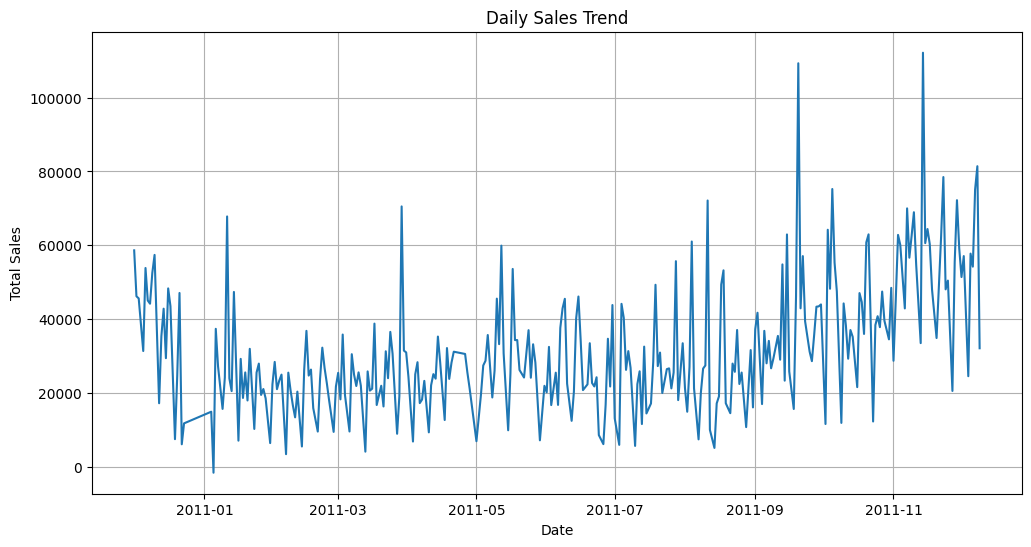

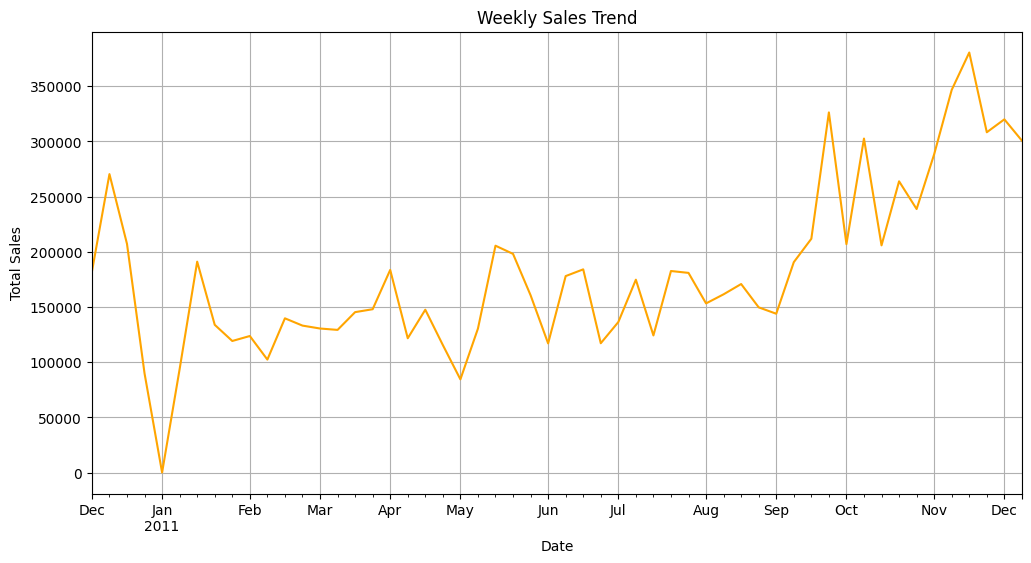

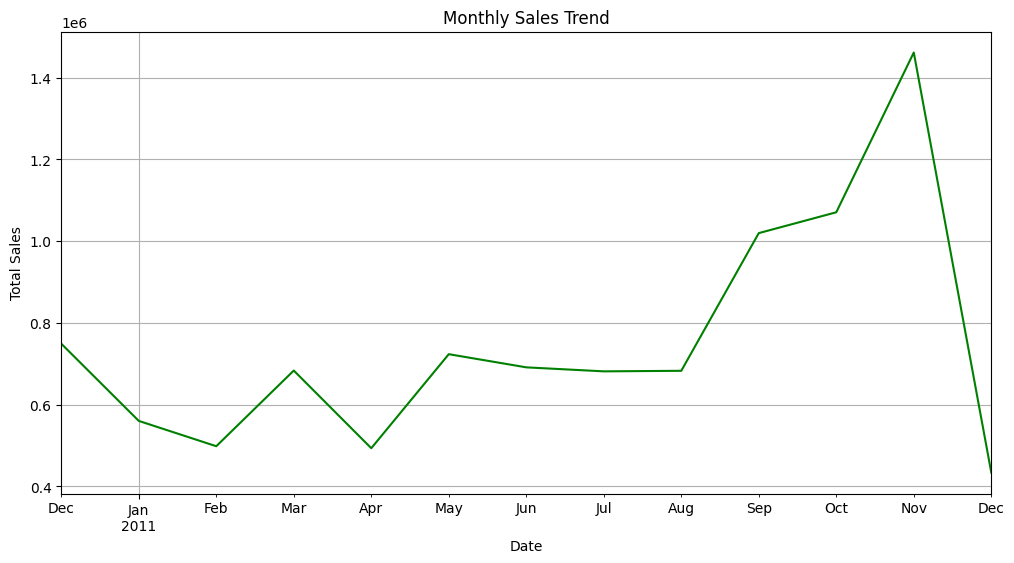

In [ ]:
# Plotting daily sales trend
plt.figure(figsize=(12, 6))
daily_sales.plot(title="Daily Sales Trend", xlabel="Date", ylabel="Total Sales")
plt.grid()

# Plotting weekly sales trend
plt.figure(figsize=(12, 6))
weekly_sales.plot(title="Weekly Sales Trend", xlabel="Date", ylabel="Total Sales", color='orange')
plt.grid()

# Plotting monthly sales trend
plt.figure(figsize=(12, 6))
monthly_sales.plot(title="Monthly Sales Trend", xlabel="Date", ylabel="Total Sales", color='green')
plt.grid()

plt.show()

2.	Which customer segments are the most profitable?
Perform clustering to identify groups of customers based on purchasing behaviour, and evaluate which segments contribute the most to revenue.


Importing Extra Libraries

In [ ]:
from sklearn.cluster import KMeans
import seaborn as sns

Data Preprocessing

This involves filtering out invalid purchases (negative or zero quantities and unit prices) and removing rows with missing CustomerID. Aggregated metrics like total sales, total transactions, and total quantity purchased per customer are computed to summarise customer behavior.



In [ ]:
# Filter data to ensure only valid purchases
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]

# Drop rows with missing CustomerID
df = df.dropna(subset=['CustomerID'])

# Create TotalSales column
df['TotalSales'] = df['Quantity'] * df['UnitPrice']

# Group data by CustomerID
customer_data = df.groupby('CustomerID').agg({
    'TotalSales': 'sum',
    'InvoiceNo': 'count',
    'Quantity': 'sum'
}).reset_index()

# Rename columns for clarity
customer_data.rename(columns={
    'InvoiceNo': 'TransactionCount',
    'Quantity': 'TotalQuantity'
}, inplace=True)

Data Preparation for Clustering

Features are scaled using StandardScaler to ensure all variables (e.g., TotalSales, TransactionCount, TotalQuantity) are on a similar scale, which is critical for accurate clustering results.

In [ ]:
# Normalise the data for clustering
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_data[['TotalSales', 'TransactionCount', 'TotalQuantity']])

Determining Optimal Number of Clusters

With some research I found that the Elbow Method is used to find the optimal number of clusters by plotting the within-cluster sum of squares (inertia) for different cluster sizes. The "elbow point" helps decide the ideal number of clusters.

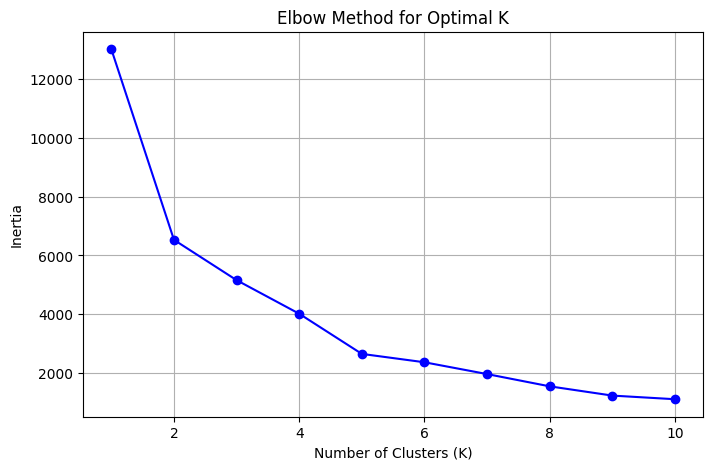

In [ ]:
# Determining the optimal clusters using the Elbow Method
inertia = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bo-')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.grid()
plt.show()

Applying K-Means Clustering

Using the optimal number of clusters determined by the Elbow Method, K-Means clustering is applied to segment customers into distinct groups. Each customer is assigned a cluster label.

In [ ]:
# Applying KMeans with optimal clusters
optimal_k = 3 # Based on the Elbow Curve
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(scaled_data)

Visualisaing and Interpreting Clusters

I have used scatterplots to visualise clusters. This helps to understand how customer segments differ in terms of their purchasing behaviour. A summary of each cluster's characteristics (average sales, transactions, and quantity) provides insights into which segments are the most profitable.

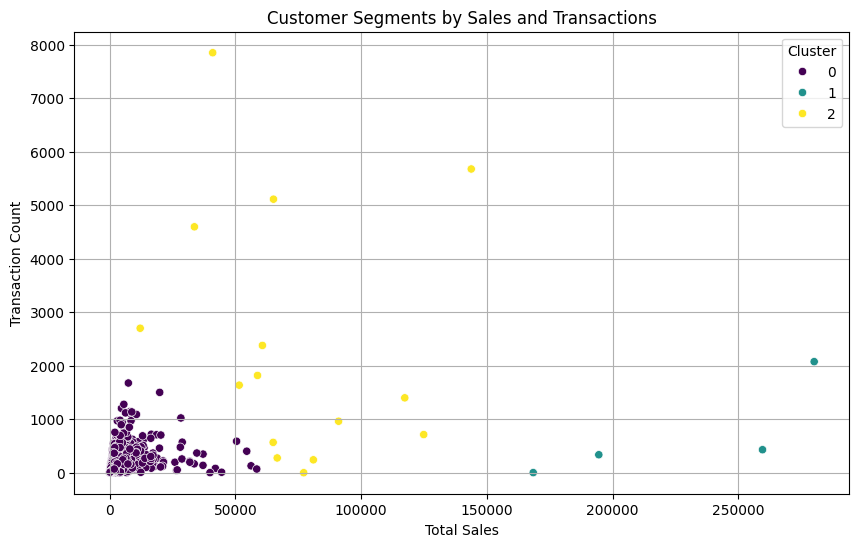

   Cluster     TotalSales  TransactionCount  TotalQuantity
0        0    1601.825493         83.146562     937.420468
1        1  225721.652500        711.750000  103007.250000
2        2   72682.466000       2395.133333   47137.600000


In [ ]:
# Visualising clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=customer_data['TotalSales'],
    y=customer_data['TransactionCount'],
    hue=customer_data['Cluster'],
    palette='viridis'
)
plt.title('Customer Segments by Sales and Transactions')
plt.xlabel('Total Sales')
plt.ylabel('Transaction Count')
plt.legend(title='Cluster')
plt.grid()
plt.show()

# Analyse clusters
cluster_summary = customer_data.groupby('Cluster').agg({
    'TotalSales': 'mean',
    'TransactionCount': 'mean',
    'TotalQuantity': 'mean'
}).reset_index()
print(cluster_summary)

3.	What factors influence customer purchases?
Explore correlations between customer demographics (country, frequency of purchase) and purchasing behaviour to understand what drives sales.


Data Preprocessing

The data is preprocessed to filter out invalid transactions and calculate meaningful metrics like TotalSales and PurchaseFrequency. Grouping by CustomerID and Country helps summarise customer behavior for analysis.

In [ ]:
# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Filter out negative or zero quantities and unit prices
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Drop rows with missing CustomerID
df = df.dropna(subset=['CustomerID'])

# Create a TotalSales column
df['TotalSales'] = df['Quantity'] * df['UnitPrice']

# Create a 'PurchaseFrequency' column (transactions per customer)
purchase_frequency = df.groupby('CustomerID').size()
df['PurchaseFrequency'] = df['CustomerID'].map(purchase_frequency)

# Summarise data by CustomerID and Country
customer_summary = df.groupby(['CustomerID', 'Country']).agg({
    'TotalSales': 'sum',
    'InvoiceNo': 'count',
    'PurchaseFrequency': 'mean'
}).reset_index()

# Rename columns for clarity
customer_summary.rename(columns={'InvoiceNo': 'TransactionCount'}, inplace=True)

Exploring Correlations Between Variables

A correlation matrix is computed and visualised to quantify relationships between TotalSales, TransactionCount, and PurchaseFrequency. The heatmap highlights the strength and direction of these correlations.



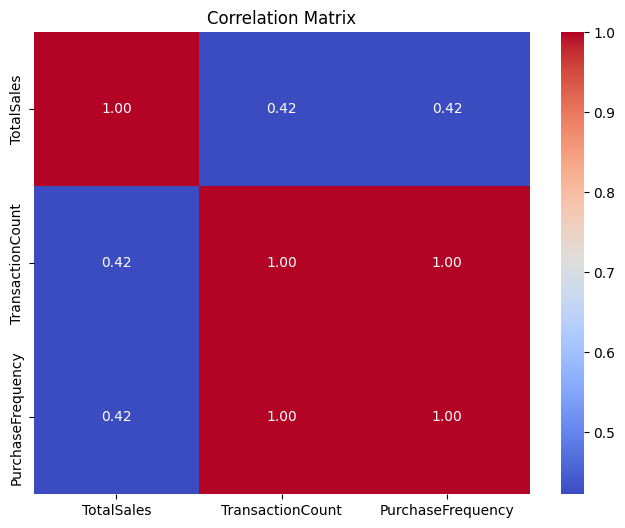

In [ ]:
# calculate correlations
correlation_matrix = customer_summary[['TotalSales', 'TransactionCount', 'PurchaseFrequency']].corr()

# Visualising correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

Analysing Country-Wise Behaviour

Country-level aggregation identifies how purchasing behavior varies geographically. Metrics such as TotalSales and AvgSalesPerCustomer are calculated, and a bar chart is plotted to showcase sales distribution across countries.

<ipython-input-14-0c92fbdf3ee9>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=country_sales.sort_values('TotalSales', ascending=False), x='Country', y='TotalSales', palette='viridis')


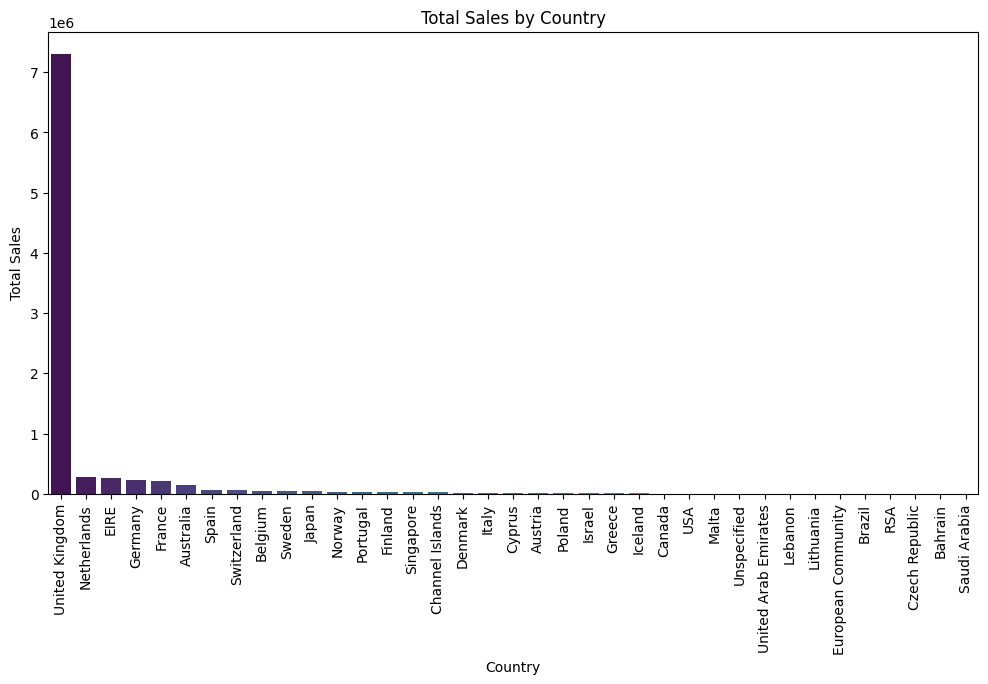

In [ ]:
# Aggregate data by country
country_sales = df.groupby('Country').agg({'TotalSales': 'sum', 'CustomerID': 'nunique'}).reset_index()
country_sales.rename(columns={'CustomerID': 'UniqueCustomers'}, inplace=True)

# Calculate average sales per customer by country
country_sales['AvgSalesPerCustomer'] = country_sales['TotalSales'] / country_sales['UniqueCustomers']

# Visualise sales by country
plt.figure(figsize=(12, 6))
sns.barplot(data=country_sales.sort_values('TotalSales', ascending=False), x='Country', y='TotalSales', palette='viridis')
plt.xticks(rotation=90)
plt.title('Total Sales by Country')
plt.xlabel('Country')
plt.ylabel('Total Sales')
plt.show()

Investigating Purchase Frequency and Sales

A scatter plot is used to explore the relationship between PurchaseFrequency and TotalSales. Color-coding by country provides additional insight into how customer behavior differs geographically.

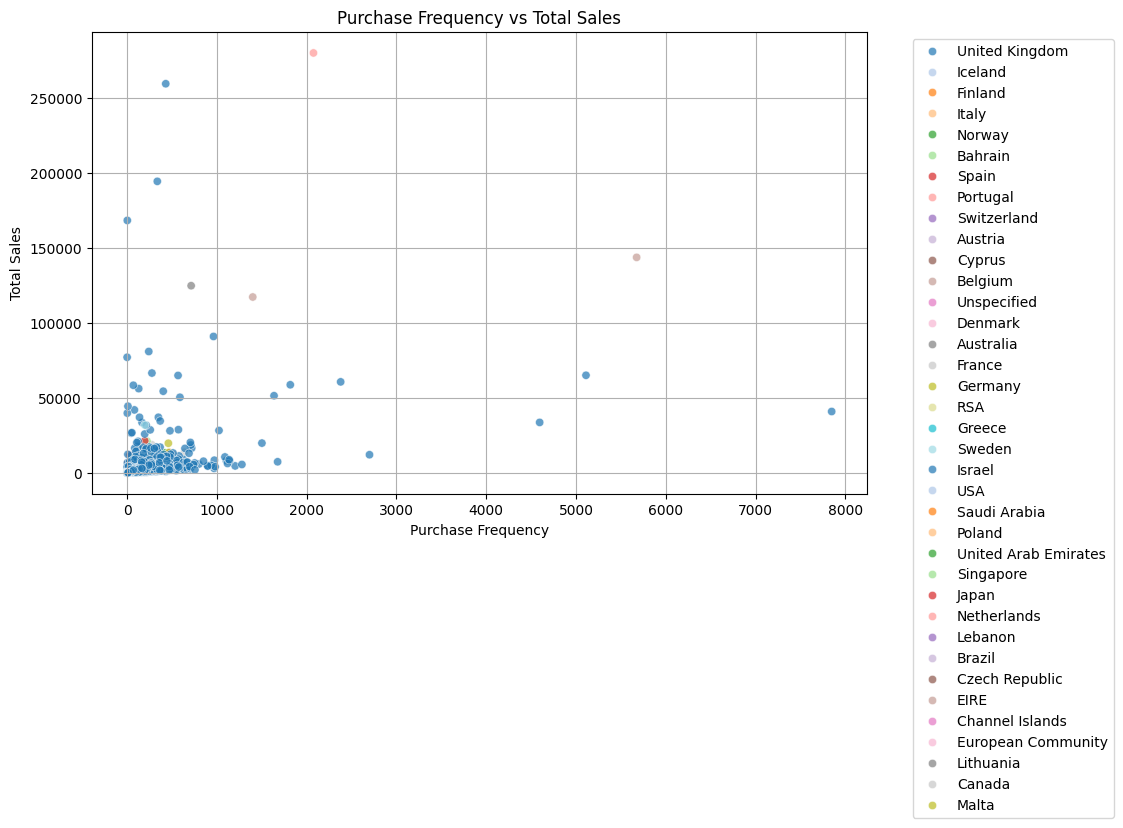

In [ ]:
# Scatter plot to explore relationship between purchase frequency and sales
plt.figure(figsize=(10, 6))
sns.scatterplot(data=customer_summary, x='PurchaseFrequency', y='TotalSales', hue='Country', palette='tab20', alpha=0.7)
plt.title('Purchase Frequency vs Total Sales')
plt.xlabel('Purchase Frequency')
plt.ylabel('Total Sales')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.show()

4.	What are the most popular products?
Identify the best-selling products by total revenue or quantity sold, and analyse their characteristics (price, description, etc.) to determine what makes them successful.


Data Preprocessing
Invalid transactions (negative or zero quantities and unit prices) are filtered out to ensure only meaningful data is analyzed. A TotalSales column is created to calculate the revenue generated by each product, and rows with missing product descriptions are removed.


In [ ]:
# Filter out rows with invalid values
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]

# Create TotalSales column
df['TotalSales'] = df['Quantity'] * df['UnitPrice']

# Drop rows with missing values in Description
df = df.dropna(subset=['Description'])

Identifying Best-Selling Products

The data is grouped by Description to calculate total quantity sold, total revenue, and average price for each product. The top 10 products are identified based on total revenue and quantity sold, allowing for insights into both profitability and popularity.


In [ ]:
# Calculate total revenue and quantity sold for each product
product_stats = df.groupby('Description').agg({
    'Quantity': 'sum',
    'TotalSales': 'sum',
    'UnitPrice': 'mean'
}).reset_index()

# sort by total revenue
top_revenue_products = product_stats.sort_values('TotalSales', ascending=False).head(10)

# sort by total quantity sold
top_quantity_products = product_stats.sort_values('Quantity', ascending=False).head(10)

print("Top 10 Products by Revenue:")
print(top_revenue_products)

print("\nTop 10 Products by Quantity Sold:")
print(top_quantity_products)

print("\nTop 10 Products by Quantity Sold:")
print(top_quantity_products)

Top 10 Products by Revenue:
                             Description  Quantity  TotalSales   UnitPrice
2319         PAPER CRAFT , LITTLE BIRDIE     80995   168469.60    2.080000
2767            REGENCY CAKESTAND 3 TIER     12402   142592.95   12.483401
3698  WHITE HANGING HEART T-LIGHT HOLDER     36725   100448.15    2.893107
1762             JUMBO BAG RED RETROSPOT     46181    85220.78    2.015878
1992      MEDIUM CERAMIC TOP STORAGE JAR     77916    81416.73    1.220303
2611                             POSTAGE      3120    77803.96   31.570482
2345                       PARTY BUNTING     15291    68844.33    4.876375
216        ASSORTED COLOUR BIRD ORNAMENT     35362    56580.34    1.680795
2130                              Manual      7173    53779.93  175.291585
2656                  RABBIT NIGHT LIGHT     27202    51346.20    2.013943

Top 10 Products by Quantity Sold:
                             Description  Quantity  TotalSales  UnitPrice
2319         PAPER CRAFT , LITTLE BIRD

Analysing Characteristics of Popular Products

The characteristics (average price, revenue, quantity) of the most popular products are examined to identify potential reasons for their success. This analysis can reveal patterns, such as affordability or specific product types driving popularity.

In [ ]:
# Analyse characteristics of top-selling products
top_products_analysis = product_stats[product_stats['Description'].isin(top_quantity_products['Description'])]

print("Characteristics of Top-Selling Products:")
print(top_products_analysis)

Characteristics of Top-Selling Products:
                             Description  Quantity  TotalSales  UnitPrice
216        ASSORTED COLOUR BIRD ORNAMENT     35362    56580.34   1.680795
1762             JUMBO BAG RED RETROSPOT     46181    85220.78   2.015878
1992      MEDIUM CERAMIC TOP STORAGE JAR     77916    81416.73   1.220303
2047             MINI PAINT SET VINTAGE      26076    16039.24   0.656523
2269     PACK OF 72 RETROSPOT CAKE CASES     33693    16394.53   0.548212
2319         PAPER CRAFT , LITTLE BIRDIE     80995   168469.60   2.080000
2600                      POPCORN HOLDER     30931    23427.71   0.843272
2656                  RABBIT NIGHT LIGHT     27202    51346.20   2.013943
3698  WHITE HANGING HEART T-LIGHT HOLDER     36725   100448.15   2.893107
3786   WORLD WAR 2 GLIDERS ASSTD DESIGNS     54415    13586.25   0.292600


Visualising the Results

Bar plots are used to visually represent the top products by revenue and quantity sold. The visualisations highlight key products and allow stakeholders to quickly identify high-performing items.

<ipython-input-19-1432c4d4801a>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


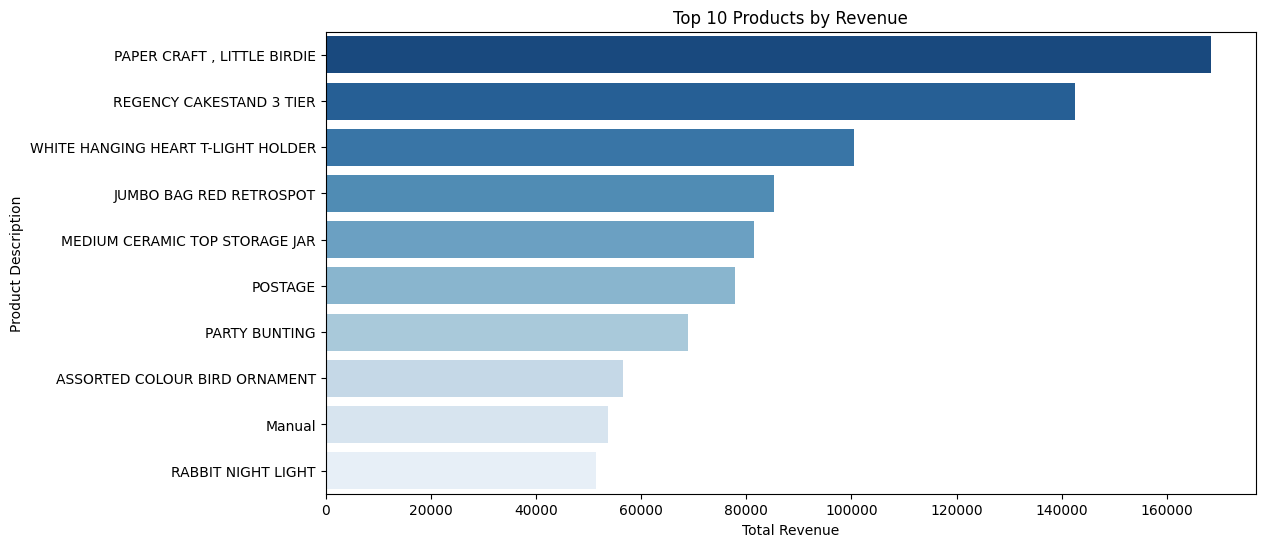

<ipython-input-19-1432c4d4801a>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


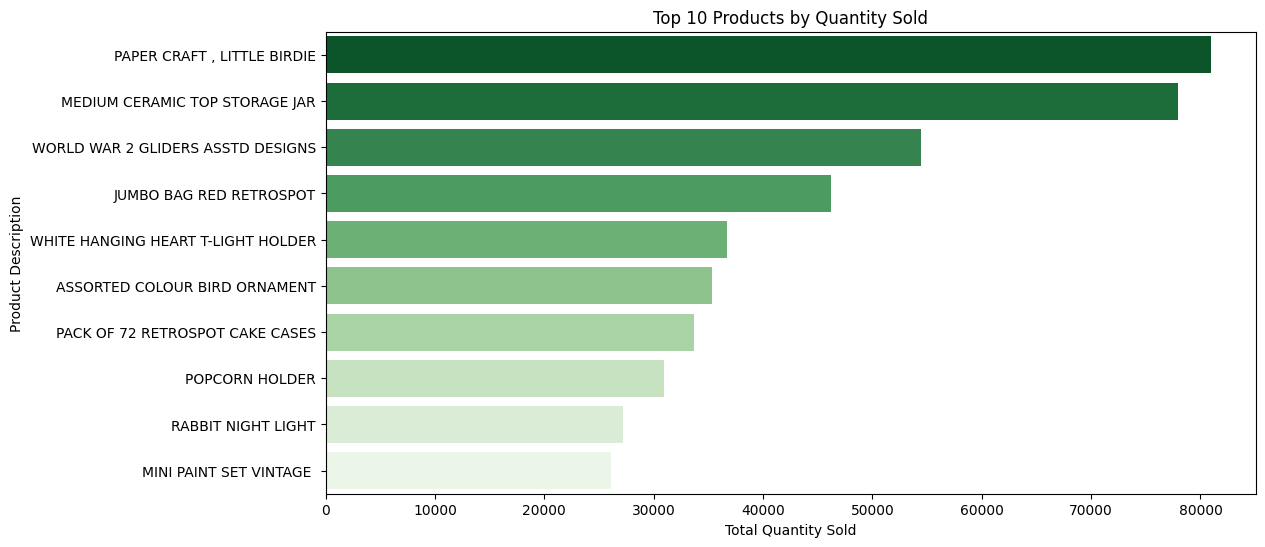

In [ ]:
# Bar plot for top products by revenue
plt.figure(figsize=(12, 6))
sns.barplot(
    x='TotalSales',
    y='Description',
    data=top_revenue_products,
    palette='Blues_r'
)
plt.title('Top 10 Products by Revenue')
plt.xlabel('Total Revenue')
plt.ylabel('Product Description')
plt.show()

# Bar plot for top products by quantity sold
plt.figure(figsize=(12, 6))
sns.barplot(
    x='Quantity',
    y='Description',
    data=top_quantity_products,
    palette='Greens_r'
)
plt.title('Top 10 Products by Quantity Sold')
plt.xlabel('Total Quantity Sold')
plt.ylabel('Product Description')
plt.show()

5.	Are there any signs of customer churn?
Using customer transaction history, classify customers as repeat buyers or one-time purchasers and predict potential churn through classification models.


This analysis aims to classify customers as repeat buyers or one-time purchasers based on transaction history and predict potential churn using a classification model.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [ ]:
import numpy as np

Data Preprocessing

This step is to ensure valid transactions and cleans the data.

Recency: Time since the last purchase.

Frequency: Total number of transactions.

Monetary: Total spending.
These features are essential for understanding customer behavior and classifying churn risk.


In [ ]:
# Ensuring only valid transactions
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]

# Drop rows with missing CustomerID
df = df.dropna(subset=['CustomerID'])

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Calculate Recency (days since last purchase), Frequency (total transactions), and Monetary (total spend) per custoemr
current_date = df['InvoiceDate'].max()
customer_data = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (current_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalSales': lambda x: (x * df.loc[x.index, 'UnitPrice']).sum()
}).reset_index()

# Renaming the columns for clarity
customer_data.columns  = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

Creating the Target Variable (Churn or Repeat Buyer)

Churned, a binary target variable is created. Customers with only one transaction are labeled as churned (1), while others are labeled as repeat buyers (0). This simplifies the classification task.

In [ ]:
# Defining churn: Customers with only 1 transaction are marked as churned
customer_data['Churned'] = np.where(customer_data['Frequency'] == 1, 1, 0)

Splitting Data into Training and Testing Sets

Dataset is split into features (Receny, Frequency, Monetary) and the target variable (Churned). It is further divided into training and testing sets to evaluate the model's performance on unseen data.

In [ ]:
# Split data into features (X) and target (y)
X = customer_data[['Recency', 'Frequency', 'Monetary']]
y = customer_data['Churned']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

Classification Model Training

A random Forest Classifier is chosen for its robustness and abiilty to handle non-linear relationships. The model is trained on the training data and used to make predictions on the test set.

In [ ]:
# Train a Random Forest Classifer
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

Model Evaluation

Model performance is assessed using a confusion matrix, classification report, and accuracy score. These metrics provide insights into the model's ability to classify churned customers accurately

In [ ]:
# Model Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))

Confusion Matrix:
 [[854   0]
 [  0 448]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       854
           1       1.00      1.00      1.00       448

    accuracy                           1.00      1302
   macro avg       1.00      1.00      1.00      1302
weighted avg       1.00      1.00      1.00      1302


Accuracy Score: 1.0


Visualising Feature Importance

Feature importance is visualised to understand which attributes (Receny, Frequency, or Monetary) contribute the most to predicting churn. This provides actionable insights for focusing customer retention efforts.

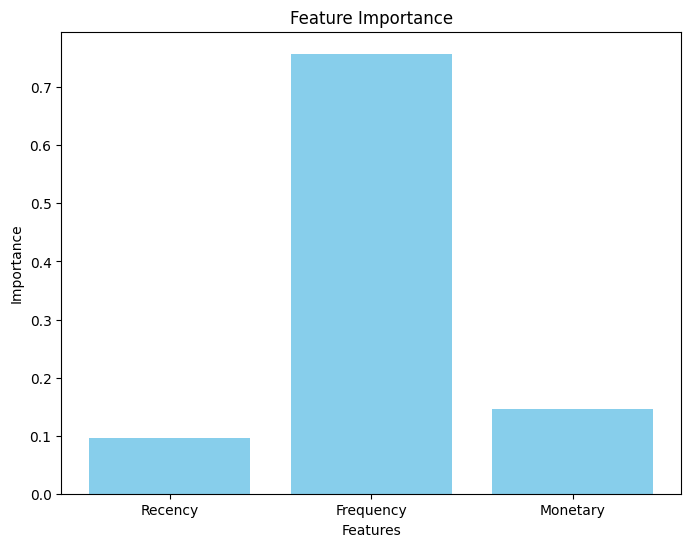

In [ ]:
# Plot feature importance
importances = clf.feature_importances_
features = X.columns
plt.figure(figsize=(8, 6))
plt.bar(features, importances, color='skyblue')
plt.title("Feature Importance")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

6.	What is the relationship between product prices and sales volume?
Investigate whether there is a correlation between the unit price of products and their sales volumes, and whether discounts or price changes impact sales patterns.


In [ ]:
from scipy.stats import pearsonr

Data Preprocessing

Data is cleaned to remove invalid rows with negative or zero Quantity or UnitPrice. The data is aggregated at the product level (StockCode), calculating metrics like average price, total sales volume, and total revenue for each product. This ensures the analysis focuses on meaningful product-level patterns.

In [ ]:
# Filtering invalid data (negative or zero values)
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]

# Creating new column for TotalSales
df['TotalSales'] = df['Quantity'] * df['UnitPrice']

# Aggregating data by StockCode to analyse at the product level
product_data = df.groupby('StockCode').agg({
    'UnitPrice': 'mean',    # Average price per product
    'Quantity': 'sum',      # Total sales volume
    'TotalSales': 'sum'     # Total revenue
}).reset_index()

Analysing the Relationship Between Price and Volume

A scatterplot visualises the relationship between product prices and sales volume. The Pearson correlation coefficient quantifies the strength and direction of this relationship. The correlation value and p-value help determine statistical significance.

Pearson cofficient correlation (PCC) is a correlation coefficient that measures linear correlation between two sets of data.

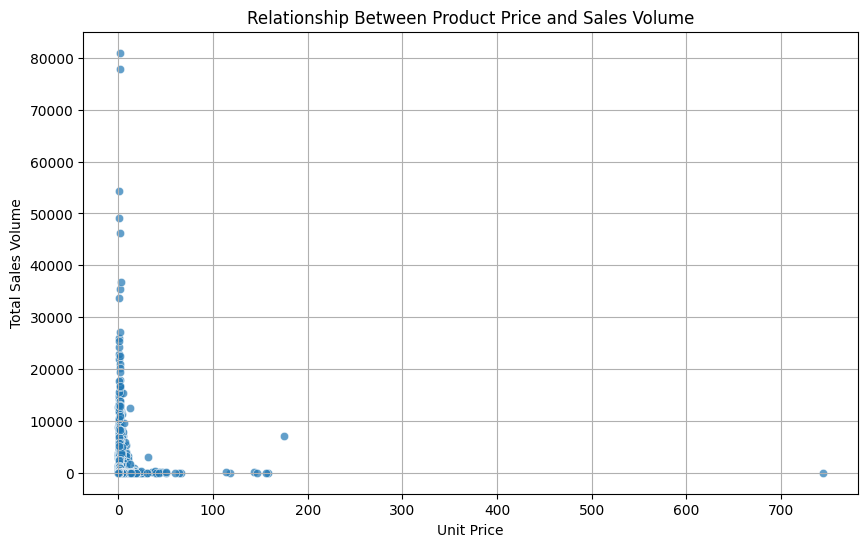

Correlation Coefficient: -0.04, P-value: 9.32e-03


In [ ]:
# Plotting scatterplot to visualise relationship
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=product_data['UnitPrice'],
    y=product_data['Quantity'],
    alpha=0.7
)
plt.title('Relationship Between Product Price and Sales Volume')
plt.xlabel('Unit Price')
plt.ylabel('Total Sales Volume')
plt.grid()
plt.show()

# Calculte Pearson correlation coefficient
correlation, p_value = pearsonr(product_data['UnitPrice'], product_data['Quantity'])
print(f'Correlation Coefficient: {correlation:.2f}, P-value: {p_value:.2e}')

Investigating Impact of Discounts or Price Changes

Products with significant price variability (measured using standard deviation of UnitPrice) are identified and analysed for their impact on sales volumes. A scatterplot visualises how variability in prices relates to total quantities sold.

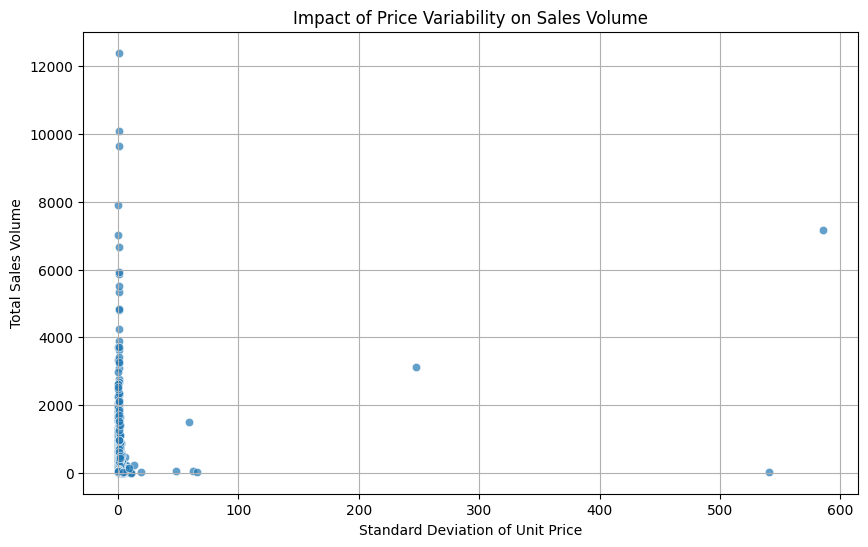

In [ ]:
# Check for price variability in products
price_variability = df.groupby('StockCode')['UnitPrice'].std().reset_index()
price_variability.columns = ['StockCode', 'PriceStdDev']

# Merge price variability with product data
product_data = product_data.merge(price_variability, on='StockCode', how='left')

# Filter products with significant price variability
variable_priced_products = product_data[product_data['PriceStdDev'] > 0.5]

# Visualize impact of price variability on sales volume
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=variable_priced_products['PriceStdDev'],
    y=variable_priced_products['Quantity'],
    alpha=0.7
)
plt.title('Impact of Price Variability on Sales Volume')
plt.xlabel('Standard Deviation of Unit Price')
plt.ylabel('Total Sales Volume')
plt.grid()
plt.show()